### В рамках решения кейса от VK  произведена обработка данных , произведен необходимый Feature engineering для более точного предсказания. Разработана модель предсказания интенсивности взаимодействия между пользователями


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
%%time
test = pd.read_csv("test.csv")
submission = pd.read_csv("submission.csv")

CPU times: total: 18.1 s
Wall time: 18.1 s


In [3]:
attr = pd.read_csv("attr.csv")

In [4]:
test['x1']=test['x1'].fillna('target')
test['t']=test['t'].fillna(0)
test['x4']=test['ego_id'].astype(str)+'_'+test['u'].astype(str)+'_'+test['v'].astype(str)

In [5]:
test['x5']=test['ego_id'].astype(str)+'_'+test['u'].astype(str)

In [16]:
data = pd.DataFrame()
data['count_links'] = test.groupby(['x5'])['v'].count()# агрегация внутри ego графа количество ребер у вершин пользователей
data['sum_time'] = test.groupby(['x5'])['t'].agg(['sum'])# агрегация внутри ego графа  суммарное вермя пользователя
data['count_time'] = test.groupby(['x5'])['t'].agg(['count'])                       #  количество
data['mean_time'] = test.groupby(['x5'])['t'].agg(['mean'])                         #  среднее время
data['median_time'] = test.groupby(['x5'])['t'].agg(['median'])                     #  медиана
data['min_time'] = test.groupby(['x5'])['t'].agg(['min'])                           #  мин
data['max_time'] = test.groupby(['x5'])['t'].agg(['max'])                           #  max
data['std_time'] = test.groupby(['x5'])['t'].agg(['std'])                           # стандартное отклонение

In [17]:
data['x5'] = data.index
data = data.reset_index(drop=True)

In [18]:
test

,ego_id,u,v,t,x1,x2,x3,x4,x5
0,8,20,19,185.7,0.000384,0.0,0.0,8_20_19,8_20
1,8,131,125,161.4,0.403446,0.0,0.0,8_131_125,8_131
2,8,73,56,127.0,0.000086,0.0,0.0,8_73_56,8_73
3,8,0,4,594.5,0.288642,0.0,0.0,8_0_4,8_0
4,8,63,73,127.0,0.0,0.0,0.0,8_63_73,8_63
...,...,...,...,...,...,...,...,...,...
40548775,1709396984676,89,0,4.8,1.167843,0.0,0.0,1709396984676_89_0,1709396984676_89
40548776,1709396984676,84,87,0.0,0.000001,0.0,0.0,1709396984676_84_87,1709396984676_84
40548777,1709396984676,8,18,83.0,1.175182,0.0,0.0,1709396984676_8_18,1709396984676_8
40548778,1709396984676,33,20,28.3,0.551102,0.0,0.0,1709396984676_33_20,1709396984676_33


In [19]:
data

,count_links,sum_time,count_time,mean_time,median_time,min_time,max_time,std_time,x5
0,185,26021.2,185,140.655135,101.30,0.0,594.5,145.859733,1005022347266_0
1,8,989.8,8,123.725000,103.95,62.4,330.0,85.739335,1005022347266_1
2,12,835.3,12,69.608333,0.00,0.0,246.3,93.380692,1005022347266_10
3,19,3448.4,19,181.494737,120.30,0.0,444.1,145.894557,1005022347266_100
4,6,2029.0,6,338.166667,357.90,73.1,472.6,138.989693,1005022347266_101
...,...,...,...,...,...,...,...,...,...
3827235,4,113.7,4,28.425000,6.10,5.0,96.5,45.387471,996432413528_5
3827236,4,320.0,4,80.000000,47.80,5.2,219.2,100.813127,996432413528_6
3827237,3,302.0,3,100.666667,145.10,6.3,150.6,81.770186,996432413528_7
3827238,2,239.2,2,119.600000,119.60,94.1,145.1,36.062446,996432413528_8


In [20]:
data = pd.merge(test[test.columns],# мерджим все агрегации к основному датасету
                   data[data.columns],
                       
                        how='left',
                        on='x5'
                        )

In [21]:
df_test = data[data['x1']=='target']# Разделяем на тестовую и тренировочную выборки
df_train = data[data['x1']!='target']
df_train['x1']=df_train['x1'].astype(float)

In [22]:
attr.sex = attr.sex.replace(-1,0)
attr.age = attr.age.replace(-1,0)
attr.school = attr.school.replace(-1,0)
attr.university = attr.university.replace(-1,0)
attr.city_id = attr.city_id.replace(-1,0)

In [23]:
test_data = pd.merge(submission[['ego_id','u','v']], df_test, on=["ego_id", "u", "v"])#фильтруем только нужные данные и удаляем дубликаты
test_data = test_data.drop_duplicates(subset=['x4'])

In [24]:
## Аналогично мерджим к основым датасетам историю по пользователям

In [25]:
test_data = test_data.merge(attr, 'left', on = ['ego_id', 'u'])
test_data.head()

,ego_id,u,v,t,x1,x2,x3,x4,x5,count_links,...,mean_time,median_time,min_time,max_time,std_time,age,city_id,sex,school,university
0,8,0,93,359.6,target,0.000000,0.0,8_0_93,8_0,122,...,278.729508,272.0,0.0,594.5,174.277046,36.0,979281502.0,2.0,213987831.0,845825535.0
1,8,0,143,6.1,target,0.000000,0.0,8_0_143,8_0,122,...,278.729508,272.0,0.0,594.5,174.277046,36.0,979281502.0,2.0,213987831.0,845825535.0
2,8,0,151,0.2,target,1.386294,0.0,8_0_151,8_0,122,...,278.729508,272.0,0.0,594.5,174.277046,36.0,979281502.0,2.0,213987831.0,845825535.0
3,8,1,24,594.5,target,0.000000,0.0,8_1_24,8_1,11,...,474.281818,594.5,8.6,594.5,187.969411,120.0,56833659.0,1.0,370230497.0,779615128.0
4,8,5,4,461.5,target,0.000000,0.0,8_5_4,8_5,9,...,420.244444,399.6,269.4,594.5,87.808088,37.0,979281502.0,1.0,814552332.0,0.0


In [26]:
attr2 = attr.copy()
attr2['v'] = attr2['u']
del attr2['u']
test_data = test_data.merge(attr2, 'left', on = ['ego_id', 'v'])
test_data.head()

,ego_id,u,v,t,x1,x2,x3,x4,x5,count_links,...,age_x,city_id_x,sex_x,school_x,university_x,age_y,city_id_y,sex_y,school_y,university_y
0,8,0,93,359.6,target,0.000000,0.0,8_0_93,8_0,122,...,36.0,979281502.0,2.0,213987831.0,845825535.0,36.0,979281502.0,2.0,734952557.0,566091832.0
1,8,0,143,6.1,target,0.000000,0.0,8_0_143,8_0,122,...,36.0,979281502.0,2.0,213987831.0,845825535.0,43.0,979281502.0,2.0,0.0,0.0
2,8,0,151,0.2,target,1.386294,0.0,8_0_151,8_0,122,...,36.0,979281502.0,2.0,213987831.0,845825535.0,18.0,979281502.0,2.0,0.0,0.0
3,8,1,24,594.5,target,0.000000,0.0,8_1_24,8_1,11,...,120.0,56833659.0,1.0,370230497.0,779615128.0,36.0,104874069.0,2.0,213987831.0,562436811.0
4,8,5,4,461.5,target,0.000000,0.0,8_5_4,8_5,9,...,37.0,979281502.0,1.0,814552332.0,0.0,37.0,0.0,1.0,213987831.0,0.0


In [27]:
df_train = df_train.merge(attr, 'left', on = ['ego_id', 'u'])
df_train.head()

,ego_id,u,v,t,x1,x2,x3,x4,x5,count_links,...,mean_time,median_time,min_time,max_time,std_time,age,city_id,sex,school,university
0,8,20,19,185.7,3.839089e-04,0.0,0.0,8_20_19,8_20,12,...,338.033333,383.90,164.1,454.6,126.749161,37.0,979281502.0,2.0,783569353.0,372487423.0
1,8,131,125,161.4,4.034464e-01,0.0,0.0,8_131_125,8_131,6,...,114.766667,161.65,0.0,198.7,89.967209,35.0,0.0,2.0,0.0,0.0
2,8,73,56,127.0,8.554643e-05,0.0,0.0,8_73_56,8_73,10,...,124.050000,127.00,96.7,127.3,9.611134,58.0,0.0,2.0,0.0,0.0
3,8,0,4,594.5,2.886418e-01,0.0,0.0,8_0_4,8_0,122,...,278.729508,272.00,0.0,594.5,174.277046,36.0,979281502.0,2.0,213987831.0,845825535.0
4,8,63,73,127.0,4.281692e-07,0.0,0.0,8_63_73,8_63,8,...,121.100000,150.05,11.5,193.8,76.461512,39.0,979281502.0,2.0,301269505.0,845825535.0


In [28]:
df_train = df_train.merge(attr2, 'left', on = ['ego_id', 'v'])
df_train.head()

,ego_id,u,v,t,x1,x2,x3,x4,x5,count_links,...,age_x,city_id_x,sex_x,school_x,university_x,age_y,city_id_y,sex_y,school_y,university_y
0,8,20,19,185.7,3.839089e-04,0.0,0.0,8_20_19,8_20,12,...,37.0,979281502.0,2.0,783569353.0,372487423.0,37.0,979281502.0,2.0,160546731.0,657399801.0
1,8,131,125,161.4,4.034464e-01,0.0,0.0,8_131_125,8_131,6,...,35.0,0.0,2.0,0.0,0.0,38.0,979281502.0,2.0,479925117.0,845825535.0
2,8,73,56,127.0,8.554643e-05,0.0,0.0,8_73_56,8_73,10,...,58.0,0.0,2.0,0.0,0.0,36.0,979281502.0,2.0,0.0,0.0
3,8,0,4,594.5,2.886418e-01,0.0,0.0,8_0_4,8_0,122,...,36.0,979281502.0,2.0,213987831.0,845825535.0,37.0,0.0,1.0,213987831.0,0.0
4,8,63,73,127.0,4.281692e-07,0.0,0.0,8_63_73,8_63,8,...,39.0,979281502.0,2.0,301269505.0,845825535.0,58.0,0.0,2.0,0.0,0.0


In [29]:
df_train = df_train.fillna(0)
test_data = test_data.fillna(0)

In [30]:
df_train.corrwith(df_train["x1"]).abs().sort_values(ascending=False).head(10)

x1             1.000000
x2             0.681151
mean_time      0.163142
median_time    0.161283
t              0.136527
max_time       0.132022
std_time       0.103251
min_time       0.098417
x3             0.089145
sum_time       0.081497
dtype: float64

In [31]:
df_train.sex_x = df_train.sex_x.astype(int)
df_train.sex_y = df_train.sex_y.astype(int)
df_train.university_x = df_train.university_x.astype(int)
df_train.university_y = df_train.university_y.astype(int)
df_train.city_id_x = df_train.city_id_x.astype(int)
df_train.city_id_y = df_train.city_id_y.astype(int)
df_train.school_x = df_train.school_x.astype(int)
df_train.school_y = df_train.school_y.astype(int)

In [32]:
test_data.sex_x = test_data.sex_x.astype(int)
test_data.sex_y = test_data.sex_y.astype(int)
test_data.university_x = test_data.university_x.astype(int)
test_data.university_y = test_data.university_y.astype(int)
test_data.city_id_x = test_data.city_id_x.astype(int)
test_data.city_id_y = test_data.city_id_y.astype(int)
test_data.school_x = test_data.school_x.astype(int)
test_data.school_y = test_data.school_y.astype(int)

In [36]:
model = CatBoostRegressor(silent= True ,iterations=400)

In [37]:
def predict_intensity(train,test,model):
    X = train.drop(['x1','x4','x5'],axis=1)
    X_predict = test.drop(['x1','x4','x5'],axis=1)
    y = train['x1']
    
    cv = KFold(n_splits=2, random_state=42, shuffle=True)
    oof = np.zeros(len(train))
    predictions = []
    for fold, (trn_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f'Fold {fold + 1}')
    
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
 
        model.fit(X_train, y_train,cat_features=['sex_x','city_id_x','school_x','university_x','sex_y','city_id_y','school_y','university_y'],
                  eval_set=[(X_valid, y_valid)],
                  verbose=100,early_stopping_rounds=50)
        oof[val_idx] = model.predict(X_valid)
        print(f'RMSE Fold{fold + 1}:{np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))}')
        predictions.append(model.predict(X_predict))
    predictions = np.mean(predictions, axis=0)
    print(f'RMSE mean:{np.sqrt(mean_squared_error(y, oof))}')
    feat_importances = pd.Series(model.feature_importances_, index=X_valid.columns)
    return predictions,feat_importances

In [38]:
test_data['x1'], feat_importances  = predict_intensity(df_train,test_data,model)

Fold 1
Learning rate set to 0.407958
0:	learn: 1.0757995	test: 1.0758168	best: 1.0758168 (0)	total: 50.6s	remaining: 5h 36m 17s
100:	learn: 0.7487329	test: 0.7440791	best: 0.7440791 (100)	total: 33m 35s	remaining: 1h 39m 27s
200:	learn: 0.7414723	test: 0.7367126	best: 0.7367126 (200)	total: 1h 5m 28s	remaining: 1h 4m 49s
300:	learn: 0.7380023	test: 0.7335903	best: 0.7335903 (300)	total: 1h 36m 33s	remaining: 31m 45s
399:	learn: 0.7354581	test: 0.7313530	best: 0.7313530 (399)	total: 2h 9m 59s	remaining: 0us

bestTest = 0.7313529907
bestIteration = 399

RMSE Fold1:0.7313529907080452
Fold 2
Learning rate set to 0.407958
0:	learn: 1.0759352	test: 1.0759148	best: 1.0759148 (0)	total: 42.3s	remaining: 4h 41m 18s
100:	learn: 0.7479546	test: 0.7433079	best: 0.7433079 (100)	total: 31m 46s	remaining: 1h 34m 5s
200:	learn: 0.7412204	test: 0.7367882	best: 0.7367882 (200)	total: 1h 3m 54s	remaining: 1h 3m 16s
300:	learn: 0.7375635	test: 0.7333799	best: 0.7333799 (300)	total: 1h 42m 50s	remaining: 3

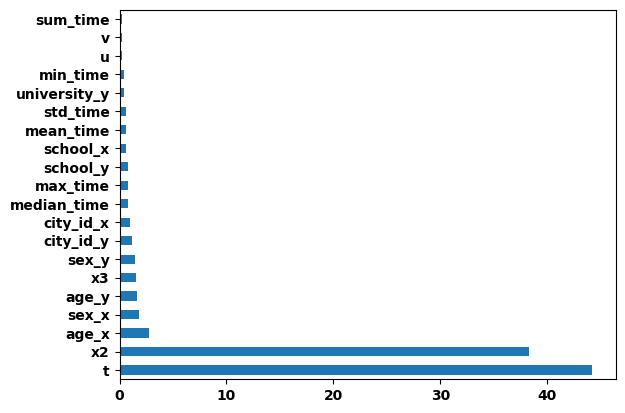

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [44]:
test_data[['ego_id','u','v','x1']].to_csv('submit_network_catboost.csv', index=False)

In [46]:
params = {
    'n_estimators': 1000, 
    'max_depth': 5, 
    'num_leaves': 31, 
    'learning_rate': 0.1, 
    'subsample': 0.995, 
    'subsample_freq': 0, 
    'colsample_bytree': 0.995, 
    'reg_alpha':  0.0001, 
    'reg_lambda': 0.0001, 
    'verbose': -1, 
    'random_state': 0, 
    'device': 'gpu'
}

model = LGBMRegressor(**params)

In [47]:
def predict_intensity(train,test,model):
    X = train.drop(['x1','x4','x5'],axis=1)
    X_predict = test.drop(['x1','x4','x5'],axis=1)
    y = train['x1']
    
    cv = KFold(n_splits=2, random_state=42, shuffle=True)
    oof = np.zeros(len(train))
    predictions = []
    for fold, (trn_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f'Fold {fold + 1}')
    
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
 
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=100,early_stopping_rounds=50)
        oof[val_idx] = model.predict(X_valid)
        print(f'RMSE Fold{fold + 1}:{np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))}')
        predictions.append(model.predict(X_predict))
    predictions = np.mean(predictions, axis=0)
    print(f'RMSE mean:{np.sqrt(mean_squared_error(y, oof))}')
    feat_importances = pd.Series(model.feature_importances_, index=X_valid.columns)
    return predictions,feat_importances

In [48]:
test_data['x1'], feat_importances  = predict_intensity(df_train,test_data,model)

Fold 1
[100]	valid_0's l2: 0.59252
[200]	valid_0's l2: 0.582148
[300]	valid_0's l2: 0.578221
[400]	valid_0's l2: 0.575598
[500]	valid_0's l2: 0.573581
[600]	valid_0's l2: 0.571694
[700]	valid_0's l2: 0.570649
[800]	valid_0's l2: 0.569773
[900]	valid_0's l2: 0.568982
[1000]	valid_0's l2: 0.568267
RMSE Fold1:0.7538349231793993
Fold 2
[100]	valid_0's l2: 0.591319
[200]	valid_0's l2: 0.58182
[300]	valid_0's l2: 0.578101
[400]	valid_0's l2: 0.575259
[500]	valid_0's l2: 0.573301
[600]	valid_0's l2: 0.571522
[700]	valid_0's l2: 0.570463
[800]	valid_0's l2: 0.569281
[900]	valid_0's l2: 0.568394
[1000]	valid_0's l2: 0.567703
RMSE Fold2:0.7534604170050488
RMSE mean:0.7536476933548962


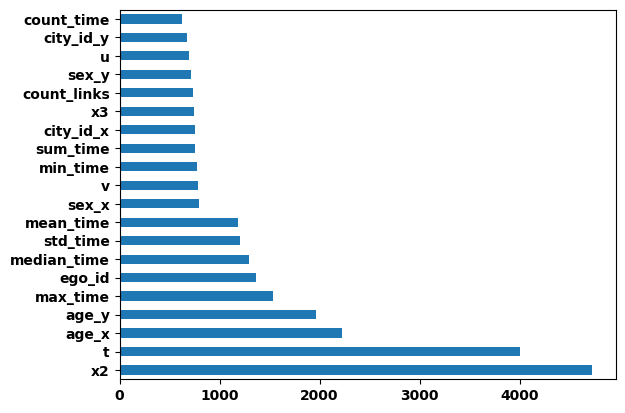

In [49]:
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [51]:
test_data[['ego_id','u','v','x1']].to_csv('submit_network_lgbm.csv', index=False)